In [1]:
from VLMManager import VLMManager
import asyncio

In [2]:
vlmmanager = VLMManager()

In [3]:
path_to_jsonl = "../../../novice/"
path_to_images = "../../../novice/images/"

In [4]:
from PIL import Image, ImageDraw
import io

In [5]:
image = Image.open(path_to_images + "image_13.jpg")

# Convert image to bytes
byte_array = io.BytesIO()
image.save(byte_array, format=image.format)
image_bytes = byte_array.getvalue()

In [6]:
bbox = vlmmanager.identify(image_bytes, "black helicopter")


image 1/1 /home/jupyter/til-24-unholy-trinity/vlm/src/saved_image.png: 608x1024 24 objects, 274.4ms
Speed: 71.5ms preprocess, 274.4ms inference, 1189.6ms postprocess per image at shape (1, 3, 1024, 1024)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


{'image': 'image_13.jpg', 'annotations': [{'caption': 'white and black drone', 'bbox': [1104, 500, 52, 40]}, {'caption': 'grey and black helicopter', 'bbox': [368, 244, 60, 40]}, {'caption': 'black helicopter', 'bbox': [736, 496, 92, 48]}]}


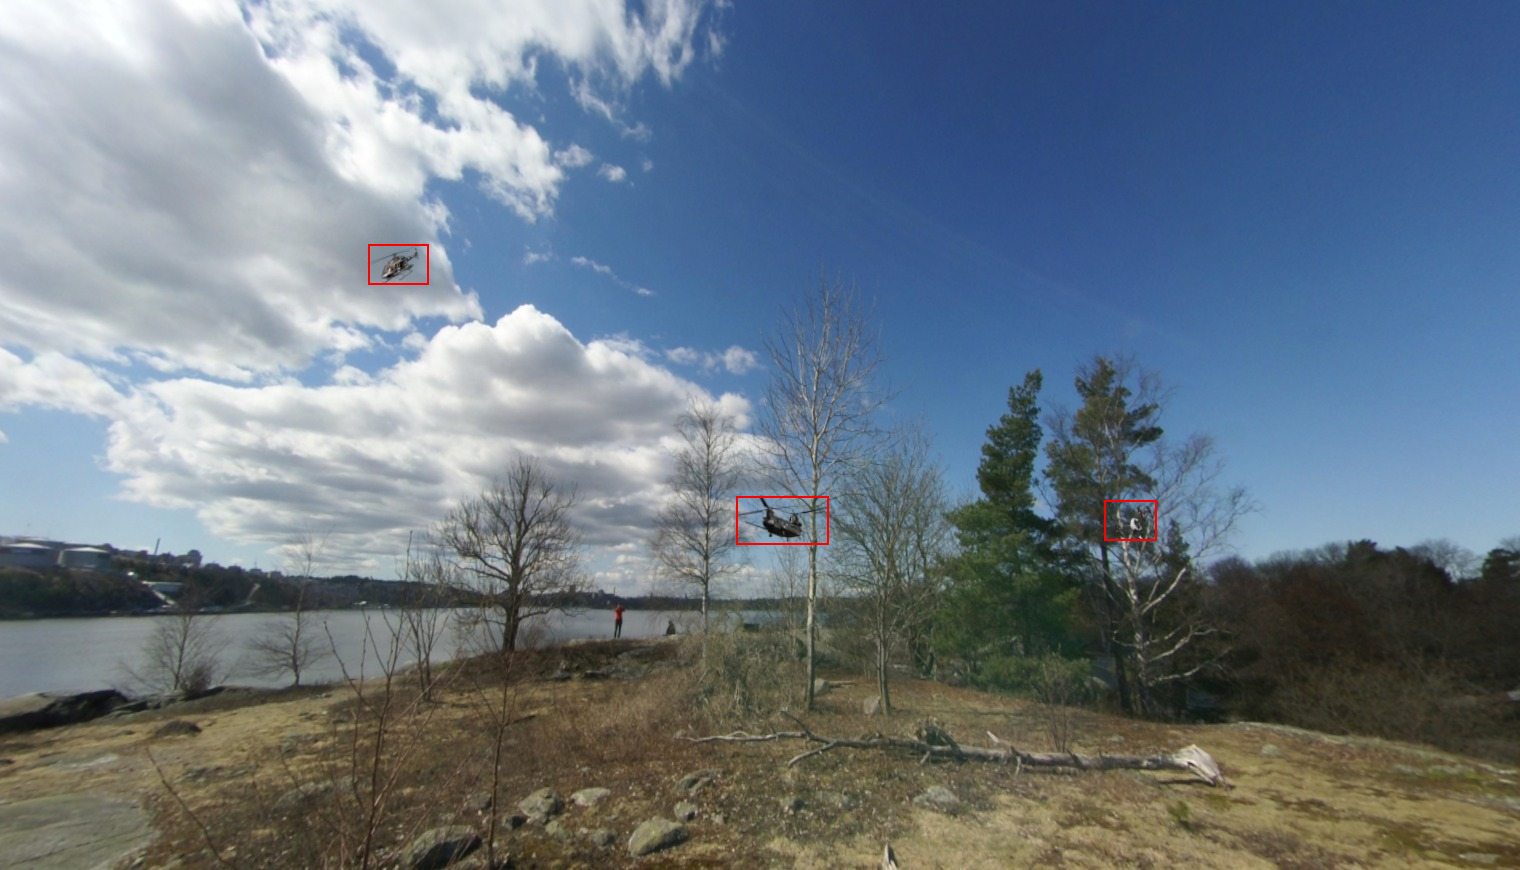

In [7]:
import json

# Load JSONL file
jsonl_file = path_to_jsonl + "vlm.jsonl"
with open(jsonl_file, "r") as f:
    annotations = [json.loads(line) for line in f]
    
image4 = annotations[13]
print(annotations[13])

# Function to draw bounding boxes on an image
def draw_boxes(image_path, annotations):
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes
    for annotation in annotations:
        bbox = annotation["bbox"]
        # Convert XYWH to XYXY format
        x1, y1 = bbox[0], bbox[1]
        x2, y2 = x1 + bbox[2], y1 + bbox[3]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    
    return image

image_path = path_to_images + image4["image"]
bbox_annotations = image4["annotations"]
draw_boxes(image_path, bbox_annotations)

In [8]:
def draw_boxes_pred(image_path, bbox):
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Convert XYWH to XYXY format
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = x1 + bbox[2], y1 + bbox[3]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    
    return image

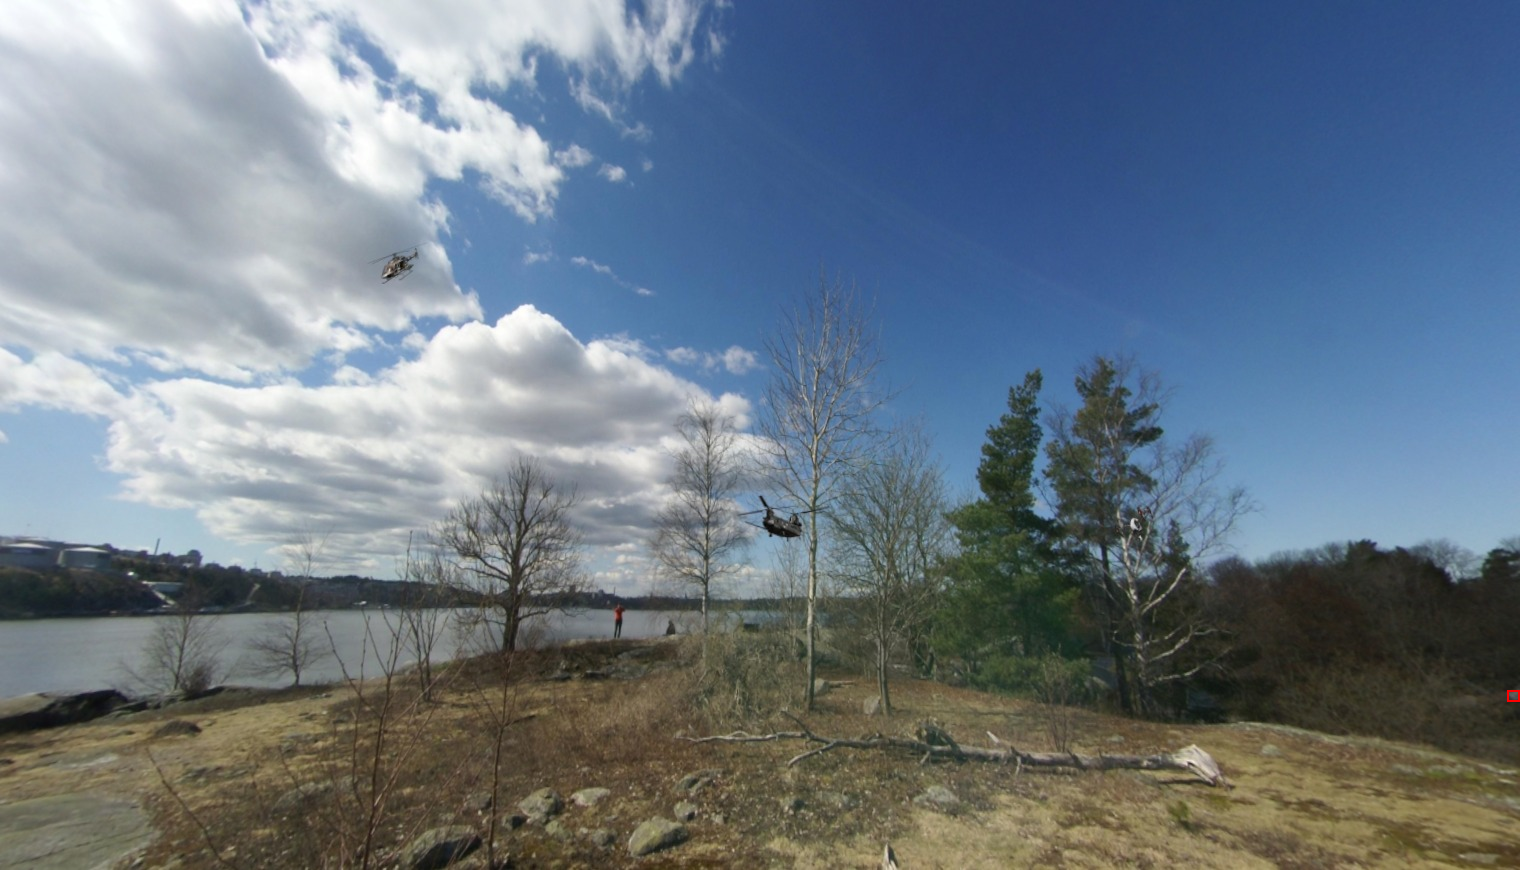

In [9]:
draw_boxes_pred(image_path, bbox)

In [ ]:
from typing import List
from PIL import Image
import torch
import numpy as np
import io
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from transformers import VisionTextDualEncoderProcessor, VisionTextDualEncoderModel, AutoTokenizer, AutoImageProcessor

class VLMManager:
    def __init__(self):
        # Initialize the model here
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        folder_path = "clip-finetune"
        
        # Load the finetuned CLIP model
        self.model = VisionTextDualEncoderModel.from_pretrained(folder_path).to(self.device)
        
        # Load the tokenizer and image processor
        self.tokenizer = AutoTokenizer.from_pretrained(folder_path)
        self.image_processor = AutoImageProcessor.from_pretrained(folder_path)
        self.processor = VisionTextDualEncoderProcessor(self.image_processor, self.tokenizer)
        
        # Initialize FastSAM model
        self.fastSAM = FastSAM('./FastSAM.pt')
        
    def identify(self, image: bytes, caption: str) -> List[int]:
        # Perform object detection with a vision-language model   
        image_pil = Image.open(io.BytesIO(image)) # PIL Opener
        output_format = "PNG"
        output_filename = "saved_image"  
        output_filepath = f"{output_filename}.{output_format.lower()}"
        image_pil.save(output_filepath, format=output_format) # Temporarily save for segmentation analysis

        # Detect Segments
        everything_results = self.fastSAM(output_filepath, device=self.device, retina_masks=True, imgsz=1024, conf=0.3, iou=0.4,)
        prompt_process = FastSAMPrompt(output_filepath, everything_results, device=self.device)
        annotations = prompt_process.everything_prompt()

        cropped_boxes = []
        original_bboxes = []

        # Loop through all the Masks
        for annotation in annotations:
            cropped_image, bounding_box = self.crop_image_with_mask(image_pil, annotation, 5) # Padding = 5
            cropped_boxes.append(cropped_image)
            original_bboxes.append(bounding_box)

        # Retrieve query scores
        best_img_idx = self.retrieve(cropped_boxes, caption)
        best_bbox = original_bboxes[best_img_idx]
        return best_bbox

    def crop_image_with_mask(self, image, mask, padding):
        image = np.array(image)
        # Convert the PyTorch tensor to a NumPy array
        mask_np = mask.cpu().numpy() if mask.is_cuda else mask.numpy()

        # Find the coordinates of non-zero pixels in the binary mask
        nonzero_coords = np.argwhere(mask_np != 0)

        # Calculate the bounding box of the non-zero pixels
        min_row, min_col = np.min(nonzero_coords, axis=0)
        max_row, max_col = np.max(nonzero_coords, axis=0)

        # Define the cropping region with padding
        min_row_pad = max(0, min_row - padding)
        min_col_pad = max(0, min_col - padding)
        max_row_pad = min(image.shape[0], max_row + padding)
        max_col_pad = min(image.shape[1], max_col + padding)

        # Crop the region from the original image using the bounding box
        cropped_image = image[min_row_pad:max_row_pad, min_col_pad:max_col_pad]

        # Resize the cropped image to the desired size
        cropped_image_pil = Image.fromarray(cropped_image).resize((224, 224))

        # Adjust bounding box coordinates for the padded image
        min_row_adjusted = min_row 
        min_col_adjusted = min_col
        max_row_adjusted = max_row 
        max_col_adjusted = max_col

        # Define the bounding box coordinates
        bounding_box = self.convert_to_left_top_width_height_format((min_row_adjusted, min_col_adjusted, max_row_adjusted, max_col_adjusted))

        return cropped_image_pil, bounding_box

    def convert_to_left_top_width_height_format(self, bounding_box):
        min_row, min_col, max_row, max_col = bounding_box
        left = min_col
        top = min_row
        width = max_col - min_col
        height = max_row - min_row
        return int(left), int(top), int(width), int(height)

    @torch.no_grad()
    def retrieve(self, elements: List[Image.Image], search_text: str) -> int:
        # Preprocess images and tokenize text
        inputs = self.processor(
            text=[search_text] * len(elements), images=elements, return_tensors="pt", padding=True
        )
        
        # Move inputs to the appropriate device
        inputs = {key: tensor.to(self.device) for key, tensor in inputs.items()}
        
        # Perform model inference
        outputs = self.model(**inputs)
        
        # Get similarity scores
        logits_per_image = outputs.logits_per_image
        print(logits_per_image)
       
        # Extract the diagonal values for similarity scores
        diagonal_values = logits_per_image.diag()
        probs = diagonal_values.softmax(dim=0)  # Convert logits to probabilities
        
        print(probs)
        
        # Find the index of the image with the highest similarity score
        most_similar_idx = torch.argmax(probs).item()
        return most_similar_idx
    
    def get_indices_of_values_above_threshold(self, values, threshold):
        return [i for i, v in enumerate(values) if v > threshold]
